# Visual Inspection of Motorcycle Connecting Rods

### Abstract
Blob analysis is the set of processes that aims to extract specific features from scene objects, usually referred to as *blobs*. 
\
This project aims the extraction of many features from a set of images where many rods are found within. In particular, for each blob the following features are required:

* <a href=#Classification>Classification/type of the rod (there are only 2 types)</a>
* <a href=#Orientation>Position and Orientation (modulo $\pi$)</a>
* <a href=#Length-and-Width>Length ($L$), Width ($W$).</a>
* <a href=#Width-at-Barycentre> Width at the barycenter ($W_B$)</a>
* <a href=#Centre-Position-and-Radius>For each hole, position of the centre and diameter size.</a>

Also, many changes may affect the images:
* Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”)
* Rods can have contact points but do not overlap one to another.  
* The inspection area may be dirty due to the presence of scattered iron powder.

### This work has been done as a project for the *Computer Vision and Image Processing* course, University of Bologna (UNIBO)

## Blob Analysis workflow
1) Read image.
2) Crop ROI (regions of interests: obtain the portions of image containing the objects we want to inspect-
3) Binarization: isolation of *FOREGROUND* and *BACKGROUND* pixels 
4) Connected component labeling: separate and enumerate the objects to be analysed
5) Feature extraction

## Dependencies
* NumPy(1.19.3)
* OpenCV(4.5.3)

# 1. Read Image

Not much to say about it, isn't it?

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = 'out/'
src_name = 'img/TESI92.BMP'
gray = cv2.imread(src_name, cv2.IMREAD_GRAYSCALE)
src = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

# 2. Crop ROI

Not needed, those images are already a ROI :)

# 3. Binarization
Binarization according to <a href='https://en.wikipedia.org/wiki/Otsu%27s_method'>Otsu's threshold</a>. Otsu's algorithm returns the optimal threshold that maximize the *inter-class variance*, an indicator that tells how well two classes (FOREGROUND and BACKGROUND) are separated by thresholding with a specific value.


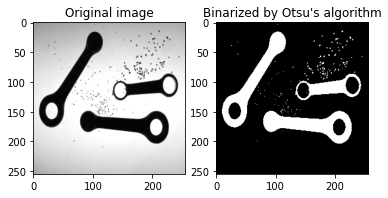

In [2]:
# Otsu's threshold is computed by OpenCV by passing the cv2.THRESH_OTSU flag
th, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
binary_image = np.asarray(binary_image/255, 'uint8') # normalize

plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(src, cmap='gray')

plt.subplot(1,2,2)
plt.title("Binarized by Otsu's algorithm")
plt.imshow(binary_image, cmap='gray')
plt.show()

# Iron powder

The powder acts as salt-and-pepper noise, which can be dealt with a *median filter*. High-density areas are filtered out by performing many iterations.
Median filter takes a set of pixel intensities as input and return the *median* value of the SORTED input.
\
\
So, assuming we have $x = [20, 8, 253, 90]$ as input and a sliding window of size $k = 3$, we will have
\
$y = median\_filter(x)$, where
\
y[1] = median[sort(20,20,8)] = median[8,20,20] = 20
\
y[2] = median[sort(20,8,253)] = median[8,20,253] = 20
\
y[3] = median[sort(8, 253, 90)] = median[8,90,253] = 90
\
y[4] = median[sort(253, 90, 90)] = median[90,90,253] = 90
\
So, accordin to that: $median\_filter([20, 8, 253, 90],\ kernel\_size=(3,3)) = [20, 20, 90, 90]$

A median filter is applied to an image by obtaining a $k\ x\ k$ neighborhood of each pixel and then update to its median value.

Median filtering actually denoises without introducing significant blur. High-density areas are filtered out by performing many iterations.

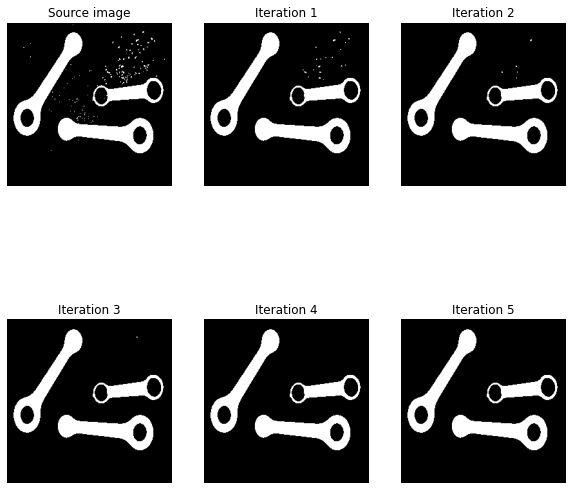

In [3]:
iterations = 5
median = binary_image.copy()
kernel_size = 3

c_max = 3                     # images per row
plt.figure(figsize=(10,10))
plt.subplot(int(iterations/c_max)+1, c_max, 1)
plt.title('Source image')
plt.axis('off')
plt.imshow(median, cmap='gray')


for i in range(iterations):
    median = cv2.medianBlur(median.copy(), kernel_size)     # median filtering
    plt.subplot(int(iterations/c_max)+1, c_max, i+2)
    plt.title("Iteration "+str(i+1))
    plt.axis('off')
    plt.imshow(median, cmap='gray')

plt.show()

# 4. Connected components labeling

Labeling consists on scanning the input binary image and check for the intensity of any foreground pixel's neighborhood, according to 4-connectivity or 8-connectivity.
\
**4-connectivity**: for each foreground pixel, if neither the upper-side and left-side pixels are background, the current pixel is labeled as a part of a new connected_component; otherwise, if at least one of them is labeled, it takes one of the two labels. If both pixels are labeled, the equivalence between those two labels must be recorded and will be handled. 

In [4]:
BACKGROUND = 0 # White
FOREGROUND = 1 # Black

In [5]:
def label_components(img):
    H, W = img.shape
    # lookup table has dinamic dimension and
    # it will grow as a new label is found
    lookup_table = [0]
    # copy of source image
    labels = np.copy(img)
    # new_label counter
    current_label = 0
    
    for i in range(H):
        for j in range(W):
            lx = BACKGROUND
            # check if foreground
            if labels[i, j] == FOREGROUND:
                # take labels of the upper and left-sided px of [i, j]
                lp = labels[i-1, j]
                lq = labels[i, j-1]
                if lp == BACKGROUND and lq == BACKGROUND:
                    # new connected component found
                    current_label += 1
                    lx = current_label
                    lookup_table.append(current_label)
                elif lp != lq and lp != BACKGROUND and lq != BACKGROUND:
                    # both left and upper pixels are foreground, but
                    # with different labels.
                    # equivalence between lp and lq has to be handled
                    lx = lq
                    lp_label = lookup_table[lp]
                    
                    # handling equivalence
                    for k in range(len(lookup_table)):
                        if lookup_table[k] == lp_label:    lookup_table[k] = lookup_table[lq]
                
                elif lq != BACKGROUND:    lx = lq
                elif lp != BACKGROUND:    lx = lp
                    
            labels[i, j] = lx  
    
    # mapping labels
    labels = np.reshape([lookup_table[k] for k in labels.flatten()], (H, W))
    
    return labels, np.unique(lookup_table)[1:]

In [6]:
labeled_components, labels = label_components(median)

Intensities are reverted to enhance intensity difference between each blob (different blobs have different labels/intensities)

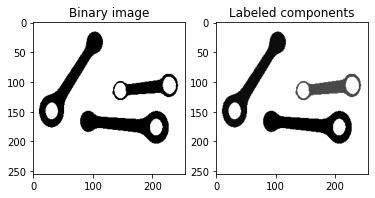

In [7]:
plt.subplot(1,2,1)
plt.title("Binary image")
plt.imshow(255 - median, cmap='gray')

plt.subplot(1,2,2)
plt.title("Labeled components")
plt.imshow(255 - labeled_components, cmap='gray')
plt.show()

### Blob separation

just cropping the original image into several windows, one for each blob.

In [8]:
def separate_blob(img, label):
    # coords
    y, x = np.where(img == label)
    
    # max and min coordinates
    x_min, y_min = np.min(x), np.min(y)
    x_max, y_max = np.max(x), np.max(y)
    
    # creating black rectangle
    out = np.zeros((y_max - y_min, x_max - x_min))
    
    # cropping
    out = img[y_min:y_max+1, x_min:x_max+1].copy()
    
    # any px that does not belong to the blob is set to zero
    out[out != label] = 0  # if we don't do so, a portion of another blob may be found inside the crop
    return (out/label).astype('uint8')

blobs = np.array([separate_blob(labeled_components, l) for l in labels], dtype=object)

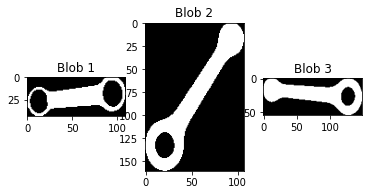

In [9]:
for i, blob in enumerate(blobs):
    plt.subplot(1, len(blobs), i+1)
    plt.title("Blob "+str(i+1))
    plt.imshow(blob, cmap='gray')

# 5. Feature Extraction

Before extracting any feature, we need to:
* Remove screws
* Remove washers
* Remove contact points between blobs

## Screws

To detect screws we can count the number of holes inside of each blob. A screw can be treated as a blob with zero holes. The number of holes is achieved by exploiting the contours

### Obtain contours


OpenCV method: <a href='https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0'>*findContours*</a> -> 	contours, hierarchy. 

For each i-th contour contours[i], the elements hierarchy[i][0] , hierarchy[i][1] , hierarchy[i][2] , and hierarchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same hierarchical level, the first child contour and the parent contour, respectively. If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of hierarchy[i] will be negative. 

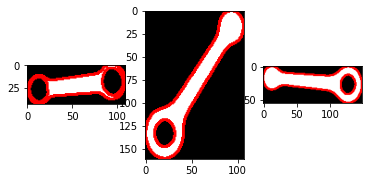

In [10]:
contour_list = [cv2.findContours(blob, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) for blob in blobs]
cnts = [c[0] for c in contour_list]
hierarchies = [np.squeeze(c[1]) for c in contour_list]

for i in range(len(blobs)):
    plt.subplot(1, len(blobs), i+1)
    plt.imshow(cv2.drawContours(cv2.cvtColor(blobs[i].copy()*255, cv2.COLOR_GRAY2RGB), cnts[i], -1, [255, 0, 0], thickness=2), cmap='gray')
    
plt.show()

### Screw detection
A screw is an object with no inner contours, so we do not consider any object having none of them

In [11]:
new_cnts = []
new_blobs = []
new_hierarchies = []
for i, h in enumerate(hierarchies):
    # 'h' mono dimensional -> no internal contours -> no holes -> screw
    
    if len(h.shape) > 1: 
        new_cnts.append(cnts[i])
        new_blobs.append(blobs[i])
        new_hierarchies.append(hierarchies[i])

cnts = new_cnts
blobs = new_blobs
hierarchies = new_hierarchies

hierarchy[i][2] is "-1" if i-th contour has no childs(e.g. it's a hole)

In [12]:
hole_cnts_indices = [np.where(h[:, 2] == -1)[0] for h in hierarchies]
hole_cnts = [np.take(cnts[i], hole_cnts_indices[i]) for i in range(len(hierarchies))]

/home/mordo/.conda/envs/a2c/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


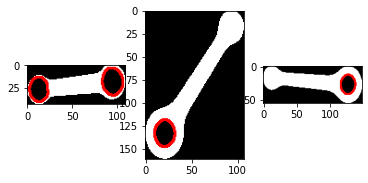

In [13]:
for i in range(len(blobs)):
    plt.subplot(1, len(blobs), i+1)
    plt.imshow(cv2.drawContours(cv2.cvtColor(blobs[i].copy()*255, cv2.COLOR_GRAY2RGB), hole_cnts[i], -1, [255, 0, 0], thickness=2), cmap='gray')

plt.show()

hierarchy[i][3] is -1 if i-th contour has no father

In [14]:
ext_cnts_indices = [np.where(h[:, 3] == -1)[0] for h in hierarchies]
ext_cnts = [np.take(cnts[i], ext_cnts_indices[i]) for i in range(len(hierarchies))]

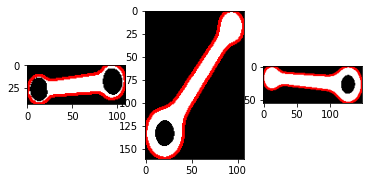

In [15]:
for i in range(len(blobs)):
    plt.subplot(1, len(blobs), i+1)
    plt.imshow(cv2.drawContours(cv2.cvtColor(blobs[i].copy()*255, cv2.COLOR_GRAY2RGB), ext_cnts[i], -1, [255, 0, 0], thickness=2), cmap='gray')

plt.show()

## Remove washers
To identify a washer we determine how much a blob is *circular* and then cut any blob having high circularity factor. 

Barycentre of the blob is needed to compute Circularity

The position of the barycentre is the sum of pixel's coordinates beloning to the same component, divided by its area

### $B =\begin{bmatrix} i_b\\j_b \end{bmatrix} = \frac{1}{A} \begin{bmatrix} \sum_{p\in Component}^{}i_p \\ \sum_{p\in Component}^{}j_p \end{bmatrix}$


The above formula can be applied to contours, we treat the number of points as the area

In [16]:
def compute_centroid(cnt):
    area = len(cnt)
    
    sum_coords = cnt.squeeze(1).sum(0)
    return np.round(sum_coords/area).astype(int)

In [17]:
barycentres = np.array([compute_centroid(cnt[0]) for cnt in ext_cnts])

## Haralick Circularity

## $C = \frac{\mu}{\sigma}$

### $\mu$ is the mean of the distances $\\$ 
$N$ is the number of pixels belonging to the contour

##### $\mu = \frac{1}{N}\sum_{k=1}^{N}d_k$

##### $\sigma^2 = \frac{1}{N}\sum_{k=1}^{N}(d_k - \mu)^2$

### $d_k$ is the distance between k-th point and the barycentre

##### $d_k = \left \| p_k - B \right \|, p_k = \begin{bmatrix}
i_k\\ 
j_k
\end{bmatrix}$

In [18]:
def haralick_circularity(cnt, barycentre):
    cnt = np.squeeze(cnt, axis=1)
    n = len(cnt)
    
    distances = np.array([np.linalg.norm(p - barycentre) for p in cnt])
    
    mu = distances.sum()/n
    sigma_square = np.sum((distances - mu) ** 2)/n
    
    return mu/np.sqrt(sigma_square)

circularities = np.round([haralick_circularity(cnt[0], barycentres[i]) for (i, cnt) in enumerate(ext_cnts)])

#### Blobs with high circularity are filtered out

In [19]:
CIRCULARITY_THRESHOLD = 3.0
# indices 
blobs_to_keep = np.squeeze(np.argwhere(circularities <= CIRCULARITY_THRESHOLD)).tolist()
# if there is just one blob, the array of indices 'blobs_to_keep' may assume an integer value
blobs_to_keep = (blobs_to_keep,) if type(blobs_to_keep) == int else blobs_to_keep

In [20]:
new_blobs = []
new_ext_cnts  = []
new_hole_cnts = []
new_barycentres = []
new_circularities = []

for i in blobs_to_keep:
    new_blobs.append(blobs[i])
    new_ext_cnts.append(ext_cnts[i])
    new_hole_cnts.append(hole_cnts[i])
    new_barycentres.append(barycentres[i])
    new_circularities.append(circularities[i])
    
blobs = np.array(new_blobs, dtype=object)
ext_cnts = np.array(new_ext_cnts)
hole_cnts = np.array(new_hole_cnts, dtype=object)
barycentres = np.array(new_barycentres)
circularities = np.array(new_circularities)

### Printing remaining blobs

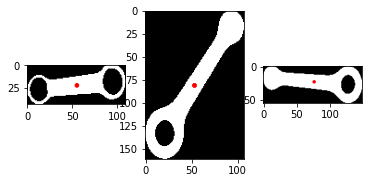

In [21]:
for i in range(len(blobs)):
    plt.subplot(1, len(blobs), i+1)
    plt.imshow(cv2.circle(cv2.cvtColor((blobs[i].copy()*255).astype('uint8'), cv2.COLOR_GRAY2RGB), barycentres[i], 1, [255, 0, 0], thickness=2), cmap='gray')

plt.show()

# Classification
Rods are classified based on the number of holes inside of them, which can be found by counting the number of internal contours of each blob.

In [22]:
rod_classes = ['A', 'B'] # A: one hole, B: two holes

classes = np.array([rod_classes[len(int_cnt)-1] for int_cnt in hole_cnts])

# Orientation

The orientation, i.e. the angle between major-axis and horizontal-axis, has been computed using the covariance matrix and seeking for eigenvector having highest eigenvalue.\
*Note: positive angle -> clockwise rotation*

In [23]:
def compute_orientation(blob):
    coords = np.vstack(np.nonzero(blob))    # coordinates of points belonging to the blob
    cov = np.cov(coords)                    # Cov matrix is computed according to coordinates
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    
    theta = np.arctan((x_v1)/(y_v1))        # angle
    return theta

In [24]:
# along major axis
orientations_rad = np.expand_dims([compute_orientation(blob) for blob in blobs], -1)
#orientations_rad = np.array([angle if angle > 0 else angle+np.pi for angle in orientations_rad]) # let the rotation be counter-clockwise only
orientations = orientations_rad*180/np.pi

# along minor axis (add 90 degrees)
orientations_min_rad = orientations_rad + np.pi/2
orientations_min = orientations_min_rad * 180/np.pi

# Length and Width

To find out the size of the MER(minimum oriented rectangle) we take the contour points of each blob and rotate it, according to the orientation found above, to let contours assume a *vertical* position

In [25]:
def rotate(points, origin, angle):
    if angle < 0:    angle = np.pi + angle      # optional
    ox, oy = origin

    x = np.array([ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy) for px, py in points])
    y = np.array([oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy) for px, py in points])
    
    abs_min = min(x.min(), y.min(), 0)                    # absolute minimum coordinate
    
    # shift every point by the absolute minimum
    coords = np.dstack([x, y]).squeeze(1) - abs_min       # prevent to have points with negative coordinates
    return np.round(coords)

squeezed_ext_cnts = [np.squeeze(cnt[0], axis=1) for cnt in ext_cnts]
rotated_ext_cnts = [rotate(np.flip(pts, axis=1), np.flip(barycentres[i]), orientations_rad[i]) for i,pts in enumerate(squeezed_ext_cnts)]

Drawing

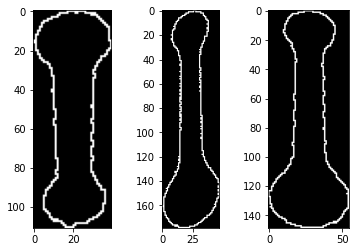

In [26]:
for i, cnt in enumerate(rotated_ext_cnts):
    plt.subplot(1, len(rotated_ext_cnts), i+1)
    max_y, max_x = int(cnt[:, 0].max()), int(cnt[:, 1].max())
    min_y, min_x = int(cnt[:, 0].min()), int(cnt[:, 1].min())
    
    img = cv2.drawContours(np.zeros((max_x+5, max_y+5)).astype('int32'), [cnt.astype(int)], -1, [1, 1, 1], lineType=cv2.LINE_4)
    
    # cropping
    img = img[min_x: max_x+1, min_y: max_y+1].copy()
    
    plt.imshow(img, cmap='gray')

plt.show()

Then, the length($L$) is computed as the difference between the maximum and minimum value along vertical-axis. Same is for the width($W$) along horizontal axis

### $L = \max{Y} - \min{Y}$ 
### $W = \max{X} - \min{X}$

In [27]:
# r[:, 1].max() = maxY
# r[:, 1].min() = minY
# r[:, 0].max() = maxX
# r[:, 0].min() = minX
measures = np.array([[r[:, 1].max() - r[:, 1].min(), r[:, 0].max() - r[:, 0].min()] for r in rotated_ext_cnts]).astype('int32')
lengths = measures[:, 0]
widths = measures[:, 1]

# Centre Position and Radius
Radius has been computed as the mean distance between (inner)contour points and their centre(barycentre)

#### $r = \frac{1}{N}\sum_{k=1}^{N}\left \| p_k - B \right \|$

In [28]:
def radius(points):
    n = len(points)
    bary = np.round(points.sum(axis=0)/n)
    distances = np.round(np.linalg.norm(points - bary, axis=1))
    
    radius = distances.mean()
    return np.round(radius).astype(int), np.round(bary).astype(int)

# Width at Barycentre
This can be achieved by intersecting external contour points and the line having the same orientation of the *minor-axis* and passing through the barycentre. Then $W_B$ determined as the mean distance between each intersection and the centre and multiplied by a factor of 2

Intersecting points are the result of a logical *AND* between line and contour image, both of them are binary and must have the same size(*shape*)

In [29]:
def barycentre_width(cnt, shape, barycentre, distance, minor_axis_angle):
    
    # return a point at distance L and aligned(given the angle) with the starting point(p0)
    def point(p0, angle, L):
        p0x, p0y = p0
        p1x = int(p0x + (L * np.cos(angle)))
        p1y = int(p0y + (L * np.sin(angle)))
        p1 = np.array((p1x, p1y)).squeeze()
        
        return p1
    
    # padding to prevent points from having negative coordinates
    pad = int(distance/2)

    # points where the line passes
    p1 = point(barycentre, minor_axis_angle, distance) + pad
    p2 = point(barycentre, minor_axis_angle, -distance) + pad

    # oriented line
    black = np.pad(np.zeros(shape).astype(int), (pad, pad)).astype('uint8')                        # black rect
    line = cv2.line(cv2.cvtColor(black.copy(), cv2.COLOR_GRAY2RGB), p1, p2, [255, 255, 255], 1)    # rgb line
    gray_line = cv2.cvtColor(line.copy(), cv2.COLOR_RGB2GRAY)                                      # gray line
    gray_line = (gray_line/255).astype(int)                                                        # binary gray line
    
    # blob contours
    contour = cv2.drawContours(cv2.cvtColor(black.copy(), cv2.COLOR_GRAY2RGB), cnt+pad, 0, [255, 255, 255], lineType=cv2.LINE_4)
    contour = cv2.cvtColor((contour/255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    
    # intersection
    intersection = np.logical_and(gray_line, contour)
    
    # distances
    points = np.flip(np.argwhere(intersection), axis=1) - pad      # coordinates of intersecting points
    distances = np.linalg.norm(points - barycentre, axis=1)        # distances between points and centre
    wb = distances.mean().round()*2
    
    # display (debug)
    #intersection_img = cv2.line(contour.copy()*255, p1, p2, [255, 0, 0], 1)
    #plt.imshow(intersection_img, cmap='gray')
    #plt.show()
    
    return wb

wbs = [barycentre_width(ext_cnts[i], blob.shape, barycentres[i], widths[i], orientations_min_rad[i]) for i,blob in enumerate(blobs)]

# Drawing
In this section, images are prepared to be printed out: the minimum oriented rectangle(MER) and the diameter of each inner-hole will be drawn within the blob to improve readability, other features will be simply written in. 

### Minimum Oriented Rectangle
MER is drawn according to the OpenCV method <a href='https://docs.opencv.org/3.4.15/d3/dc0/group__imgproc__shape.html#gaf78d467e024b4d7936cf9397185d2f5c'>*boxPoints*</a> which, for a given MER, returns 4 vertices of the corresponding rectangle.
\
Every blob is wrapped inside a bigger empty image to improve the visibility of the MER

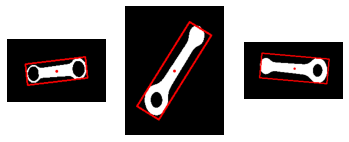

In [30]:
# padding
pad = 35

# minimum oriented rectangles: [centroid, [L, W], orientation(degree)]
mers = [[tuple(barycentres[i].astype('float32')+pad), measures[i].tolist(), orientations[i][0]] for i in range(len(blobs))]
boundary_box = []

# boxPoints retrieves rect corner points
boxes = np.array([cv2.boxPoints(mer) for mer in mers]).astype(int)

for i, blob in enumerate(blobs):
    # boundary box
    t = cv2.drawContours(cv2.cvtColor(np.pad(blob, (pad, pad)).copy().astype('uint8')*255, cv2.COLOR_GRAY2RGB), [boxes[i]], 0, [255,0,0], 2)
    
    # barycentre
    t = cv2.circle(t, barycentres[i] + pad, 1, [255, 0, 0], thickness=2)
    
    boundary_box.append(t)
    plt.axis('off')
    plt.subplot(1, len(blobs), i+1)
    plt.imshow(t, cmap='gray')

plt.axis('off')
plt.show()

Utility function: given a source image and a set of points, representing the contour of a hole, draws a red diameter arrowed line along the diameter and a text that underlines its length

In [31]:
def draw_diameter(src, points, padding):
    rad, centre = radius(points)
    cx, cy = centre
    
    min_x = points[:, 0].min()
    max_x = points[:, 0].max()
    
    p1 = centre - [cx - min_x - 1, 0] + padding
    p2 = centre + [max_x - cx - 1, 0] + padding

    text_point = centre + [-4, 7] + padding
    out = cv2.arrowedLine(src.copy(), p1, p2, [255, 0, 0], tipLength=0.15)    # tipLength = arrow length
    out = cv2.arrowedLine(out.copy(), p2, p1, [255, 0, 0], tipLength=0.15)
    #out = cv2.circle(out.copy(), centre+padding, 1, [255, 0, 0], 1)
    out = cv2.putText(out.copy().astype('uint8'), str(2*rad),text_point, cv2.FONT_HERSHEY_SIMPLEX, 0.20,  [255, 0, 0])
    return out

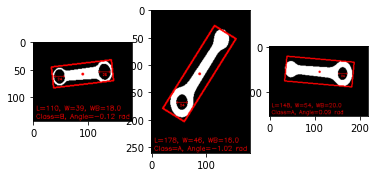

In [32]:
# add 30 empty rows (bottom-side) to be filled with text
boundary_box = [np.vstack((blob, np.zeros((30, blob.shape[1], 3))) ) for blob in boundary_box]

# add few columns (left-side and right-side) to prevent the text to outlie the image
MIN_COLS = 180
boundary_box = [b if (b.shape[1] >= MIN_COLS) else np.hstack((b, np.zeros((b.shape[0], MIN_COLS-b.shape[1], 3)))) for b in boundary_box]

# for each blob
for i, holes in enumerate(hole_cnts):
    # for each hole
    for hole in holes:
        hole = hole.squeeze(1)
        rad, centroid = radius(hole)
        
        # draw diameter
        img = draw_diameter(boundary_box[i], hole, pad)
        
        boundary_box[i] = img # this must stay inside the nested for, because a blob may have more than one hole
        
    # draw text
    out_text_position = np.array((5, boundary_box[i].shape[0]-5))
    str_out = f"Class={classes[i]}, Angle={np.round(orientations_rad[i][0],2)} rad"
    boundary_box[i] = cv2.putText(boundary_box[i], str_out, out_text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.40, [255, 0, 0])
    str_out = f"L={lengths[i]}, W={widths[i]}, WB={wbs[i]}"
    boundary_box[i] = cv2.putText(boundary_box[i], str_out, out_text_position-[0, 15], cv2.FONT_HERSHEY_SIMPLEX, 0.40, [255, 0, 0])

    plt.subplot(1, len(hole_cnts), i+1)
    plt.imshow(boundary_box[i], cmap='gray')

plt.show()

In [33]:
out_names = [f"{OUT_DIR}{src_name}_{i}_{classes[i]}.bmp" for i,b in enumerate(boundary_box)]
[cv2.imwrite(out_names[i], cv2.cvtColor(boundary_box[i], cv2.COLOR_RGB2BGR))  for i,b in enumerate(boundary_box)];

In [34]:
[cv2.imshow(out_names[i], cv2.cvtColor(boundary_box[i], cv2.COLOR_RGB2BGR))  for i,b in enumerate(boundary_box)];
cv2.waitKey(0)
cv2.destroyAllWindows()